In [39]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
from functions import *
from models import *
import tensorflow as tf
from livelossplot import PlotLossesKeras
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # pick a number < 4 on ML4HEP; < 3 on Voltan 
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [56]:
stream = "gd1_tail"

In [90]:
df, file = load_file(stream = stream, percent_bkg = 1)

Before reduction, stream stars make up 0.039% of the dataset.
After reduction, stream stars make up 3.713% of the dataset.


In [91]:
# a = np.load('../ViaMachinae/knownstreams.npz')
# stream = pd.DataFrame(a['Gaia3'][:,[3,2,1,0,4,5]], columns = ['μ_δ','μ_α','δ','α','mag','color'])
# plt.figure(figsize=(3.7,3), dpi=150, tight_layout=True)
# plt.scatter(stream.α,stream.δ,color='black',s=0.2, label="Stream")
# plt.xlabel(r"$\alpha$ [\textdegree]")
# plt.ylabel(r"$\delta$ [\textdegree]");

In [92]:
# ### Get offsets 
# pieces = file.split('_')
# for piece in pieces:
#     if piece.startswith("l"): 
#         l = float(piece[1:])
#     elif piece.startswith("b"): 
#         b = float(piece[1:])
# print(l,b)

# plt.figure(figsize=(3.7,3), dpi=150, tight_layout=True)
# plt.hist2d(df.α,df.δ,bins=50)
# # plt.colorbar()
# plt.scatter(stream.α-l,stream.δ-b,color='gray',s=0.2, label="Stream")
# plt.xlabel(r"$\alpha$ [\textdegree]")
# plt.ylabel(r"$\delta$ [\textdegree]");

In [93]:
# plt.figure(figsize=(3.7,3), dpi=150, tight_layout=True)
# plt.hist2d(df.α,df.δ,bins=50)
# plt.colorbar()
# # plt.scatter(jhelum.α-l,jhelum.δ+b,color='white',s=0.2, label="Jhelum")
# plt.xlabel(r"$\alpha$ [\textdegree]")
# plt.ylabel(r"$\delta$ [\textdegree]");

### Optional: Exclude a hotspot

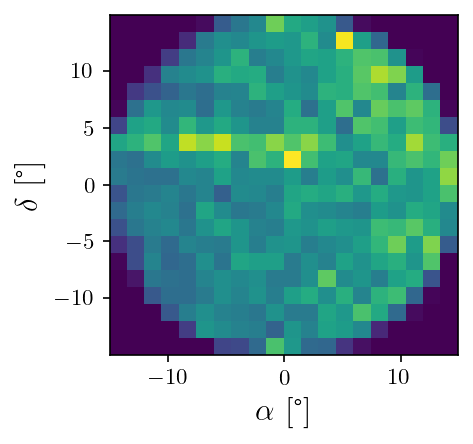

In [94]:
plt.figure(figsize=(3,3),dpi=150)
hist = plt.hist2d(df.α, df.δ, bins=20)
plt.xlabel(r'$\alpha$ [\textdegree]');
plt.ylabel(r'$\delta$ [\textdegree]');

In [95]:
# Get indices for hotspot bin to exclude
i, j = np.unravel_index(hist[0].argmax(), hist[0].shape)

# Exclude this bin based on bin edges 
df2 = df[(df.α < hist[1][i]) | (df.α > hist[1][i+1]) | 
         (df.δ < hist[1][j]) | (df.δ > hist[1][j+1])]

print("{:.1f}% of the dataset remains.".format(100*len(df2)/len(df)))

# Redefine dataframe
df = df2

99.4% of the dataset remains.


### Prepare datasets for training

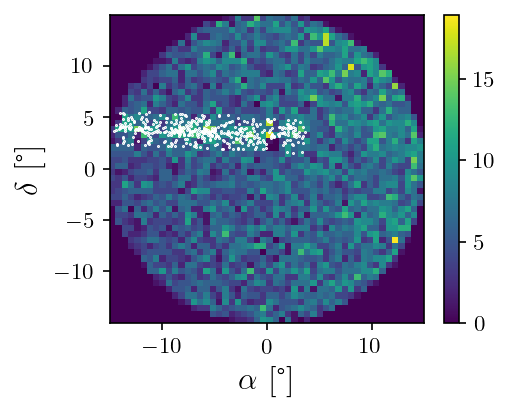

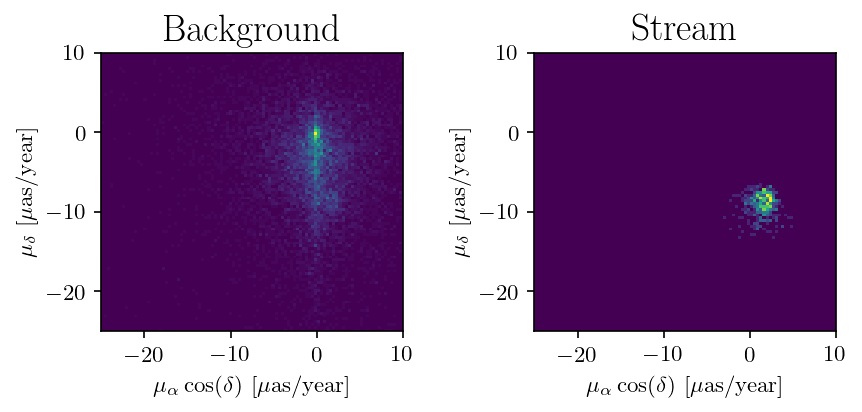

In [96]:
visualize_stream(df, show_stream=True)

Text(0.5, 0, 'GD1 Tail')

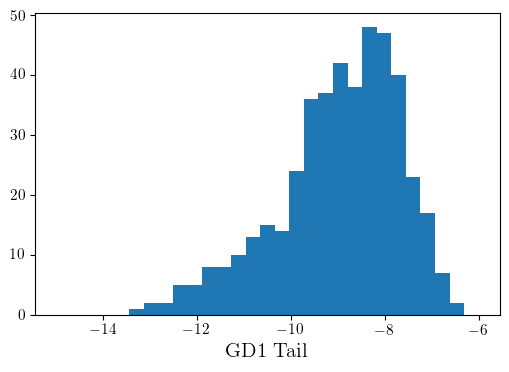

In [97]:
plt.hist(df[df.stream].μ_δ, bins=np.linspace(-15,-6,30));
plt.xlabel('GD1 Tail')

Sideband region: [-15,-5]
Signal region: [-11,-7]
Total counts: SR = 1,928, SB = 2,091
Signal region has 389 stream and 1,539 bkg events (25.28%).
Sideband region has 55 stream and 2,036 bkg events (2.70%).
f_sig = 9.4X f_sideband.


/clusterfs/ml4hep/mpettee/GaiaCWoLa/functions.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_slice['label'] = np.where(((df_slice.μ_δ > sr_min) & (df_slice.μ_δ < sr_max)), 1, 0)


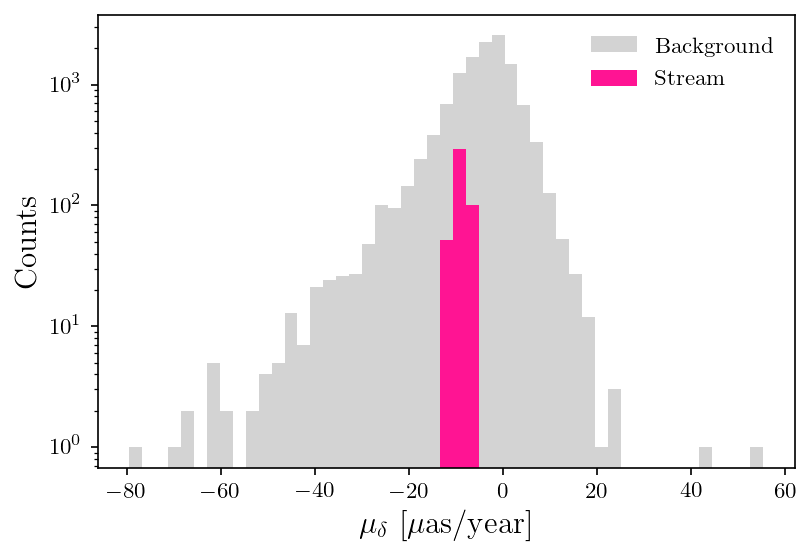

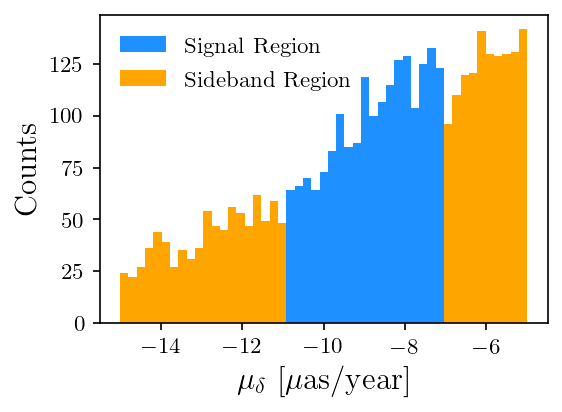

In [98]:
df = signal_sideband(df, stream = stream)

A quick experiment... remove all real stream stars from the sideband region:

In [63]:
# df = df[((df.label == 0) & (df.stream == False)) | (df.label == 1)]

Add sample weights to stream stars:

In [102]:
### Signal region only 
# stream_stars_in_sb = (df['stream'] == True) & (df['label'] == 1)
# df["weight"] = np.where(stream_stars_in_sb, 5, 1)

### Throughout signal & sideband regions
df["weight"] = np.where(df['stream'] == True, 5, 1)

/tmp/ipykernel_19455/56803264.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["weight"] = np.where(df['stream'] == True, 5, 1)


# Train

In [114]:
tf.keras.backend.clear_session()

Using sample weights
Training on 2,813 events.

Training fold #0...

Epoch 00001: val_loss improved from inf to 0.68134, saving model to ./trained_models/test/kfold0_loop0_weights.h5
72/72 - 0s - loss: 0.6924 - accuracy: 0.5345 - val_loss: 0.6813 - val_accuracy: 0.5909

Epoch 00001: val_loss improved from inf to 0.67962, saving model to ./trained_models/test/kfold0_loop1_weights.h5
72/72 - 0s - loss: 0.6900 - accuracy: 0.5433 - val_loss: 0.6796 - val_accuracy: 0.5707
Best losses: [0.6924090385437012, 0.6899552345275879]
Loading weights from best loop, i.e. loop #1.
Score for fold 0: loss of 0.68; accuracy of 57.07%

Training fold #1...

Epoch 00001: val_loss improved from inf to 0.67965, saving model to ./trained_models/test/kfold1_loop0_weights.h5
72/72 - 0s - loss: 0.6883 - accuracy: 0.5534 - val_loss: 0.6797 - val_accuracy: 0.5716

Epoch 00001: val_loss improved from inf to 0.68500, saving model to ./trained_models/test/kfold1_loop1_weights.h5
72/72 - 0s - loss: 0.6892 - accuracy: 0

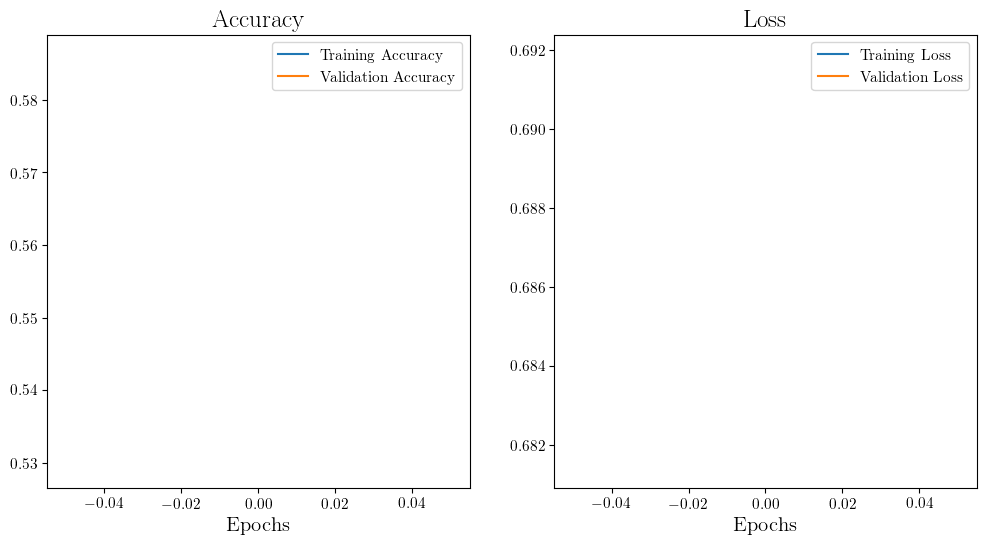

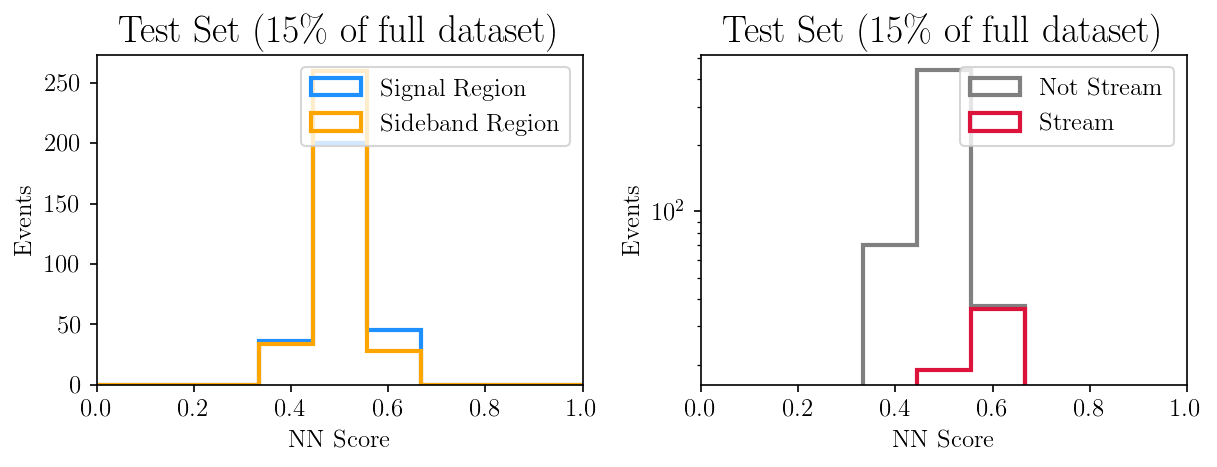

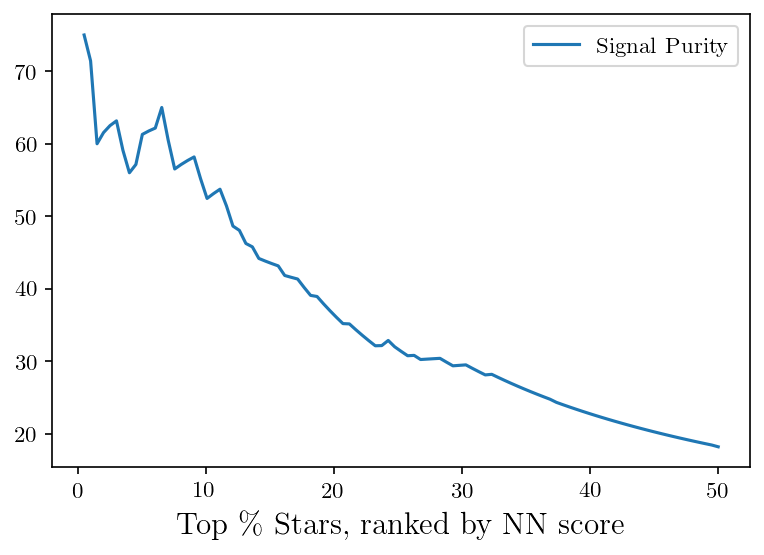

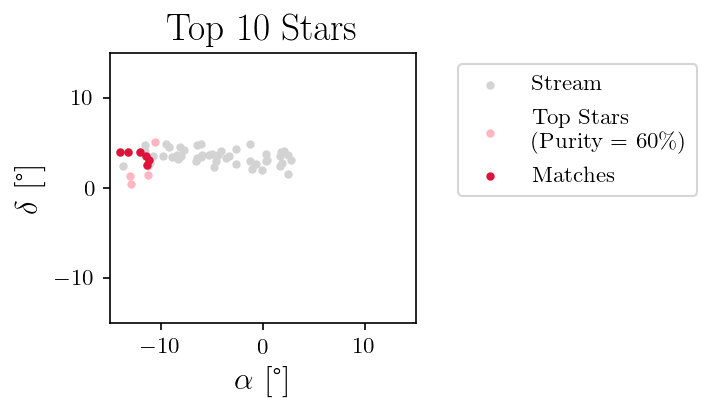

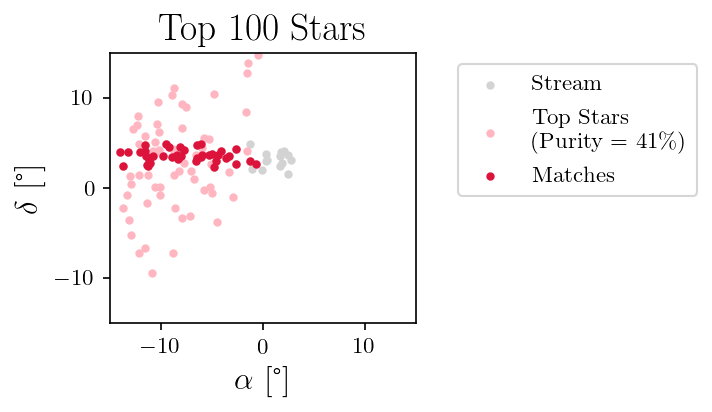

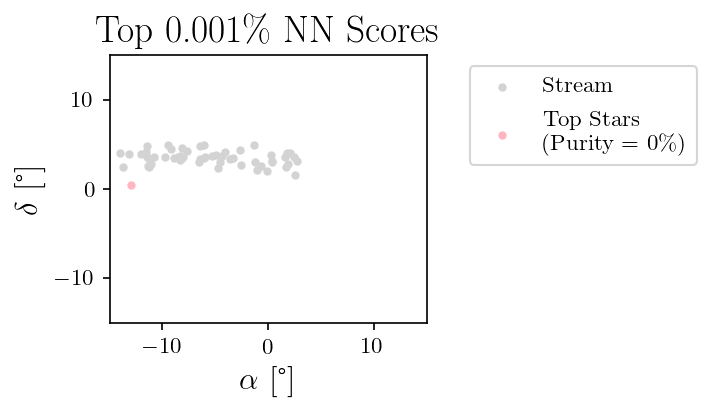

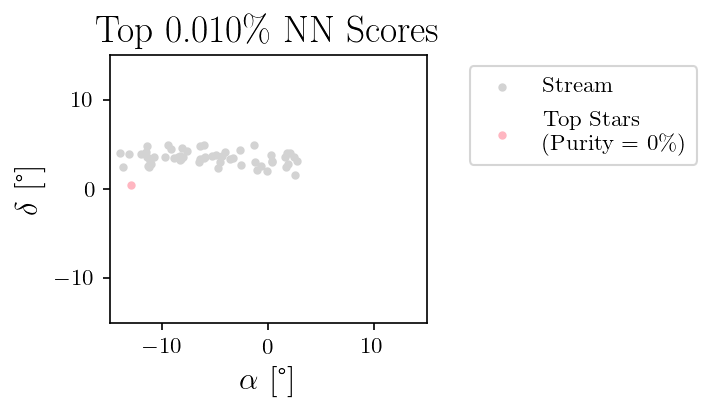

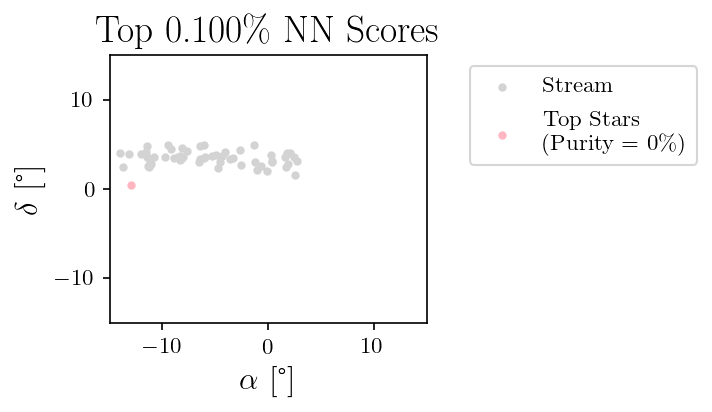

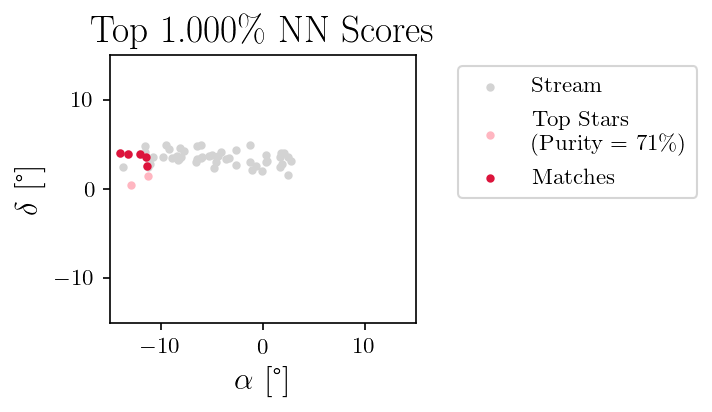

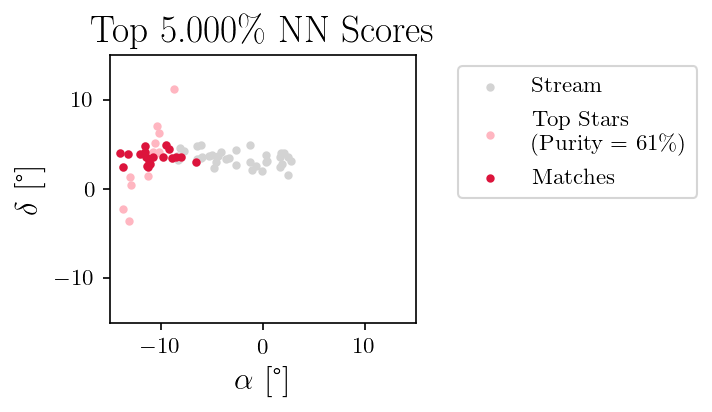

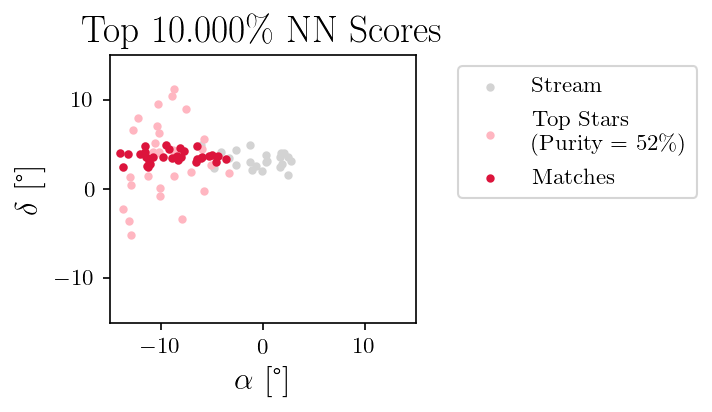

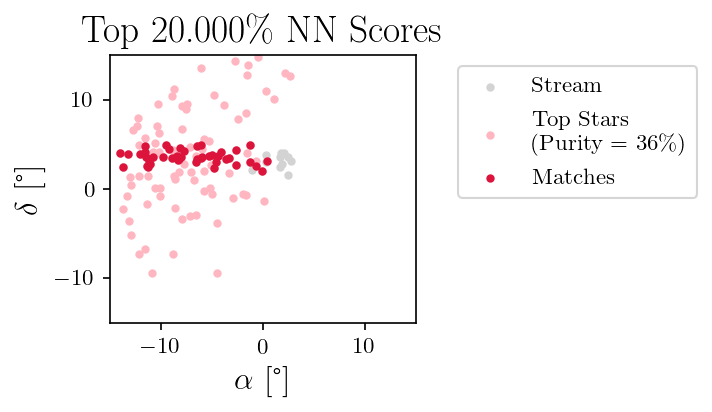

In [116]:
train(df, epochs=1, layer_size=64, dropout=0.2, l2_reg=0, patience=30, 
      n_folds=3, best_of_n_loops=2)
